In [26]:
import torch
import torchvision.models as models
import onnx
import onnxruntime as ort
import numpy as np
import time
from PIL import Image

In [56]:
def get_mean_inference_time(ort_session, input_data, n=1000):
    total_time = 0
    for _ in range(n):
        start_time = time.time()
        outputs = ort_session.run(None, {'input': np.array(input_data)})
        end_time = time.time()
        total_time += end_time - start_time
    print(f"Среднее время предсказания: {total_time / n:.4f} секунд")

### Как преобразовать torch модель в ONNX
Можно преобразовывать модели и из других библиотек Sklearn, TensorFlow и тд, в этом и прелесть ONNX

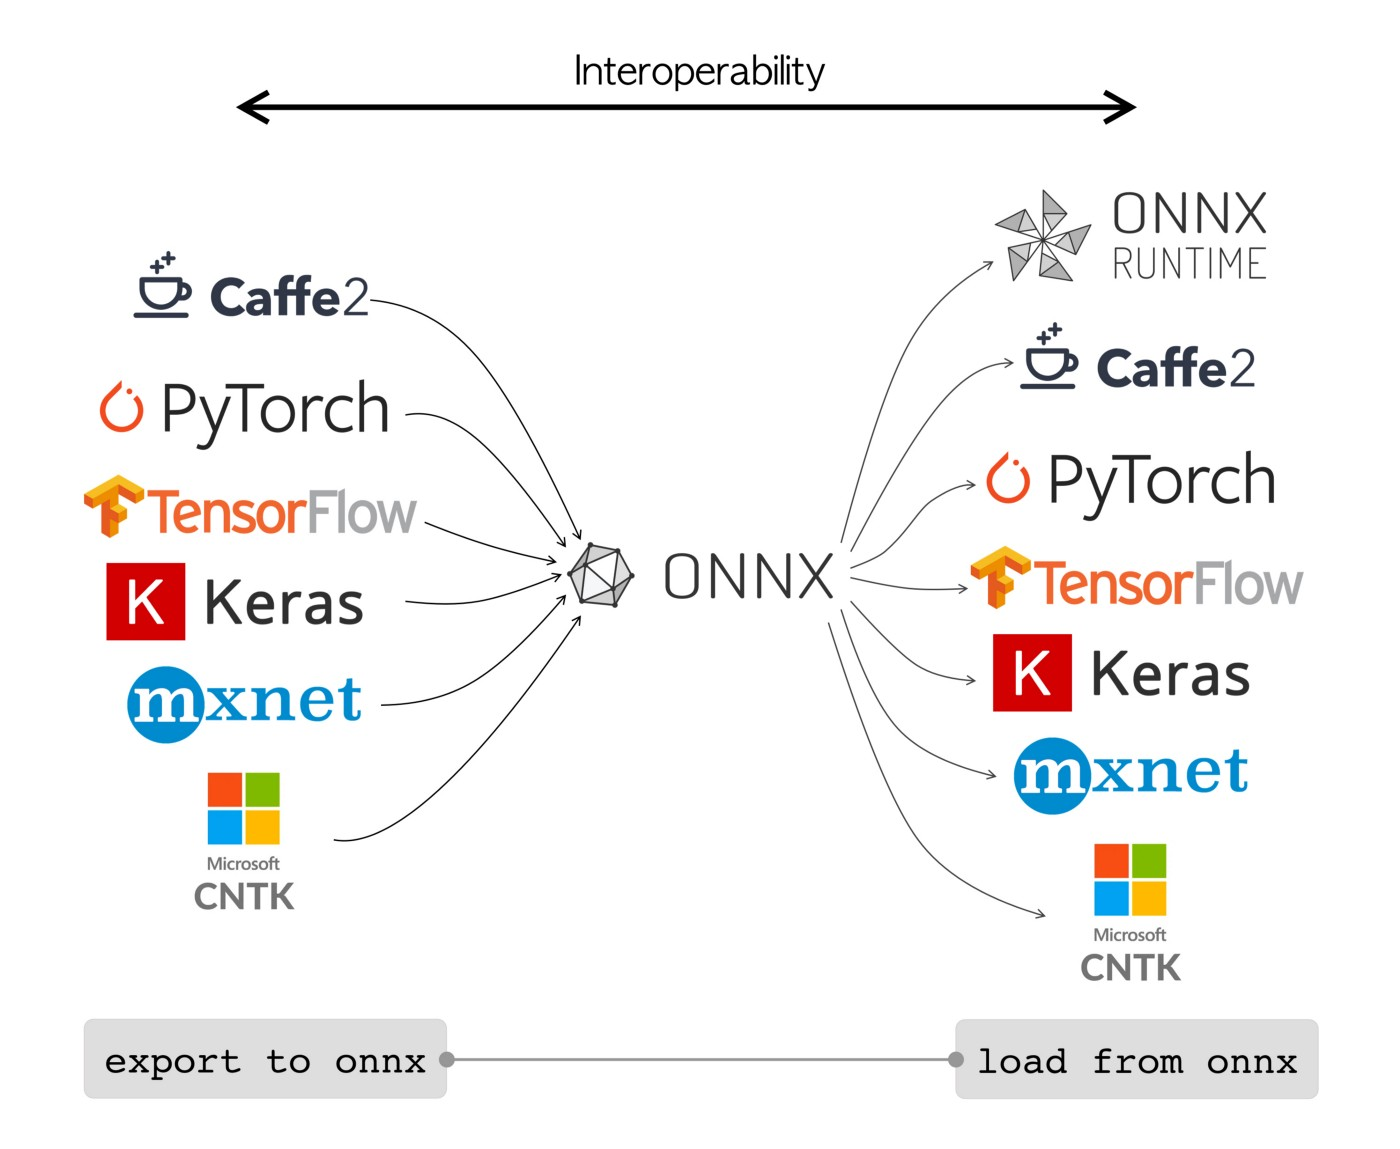

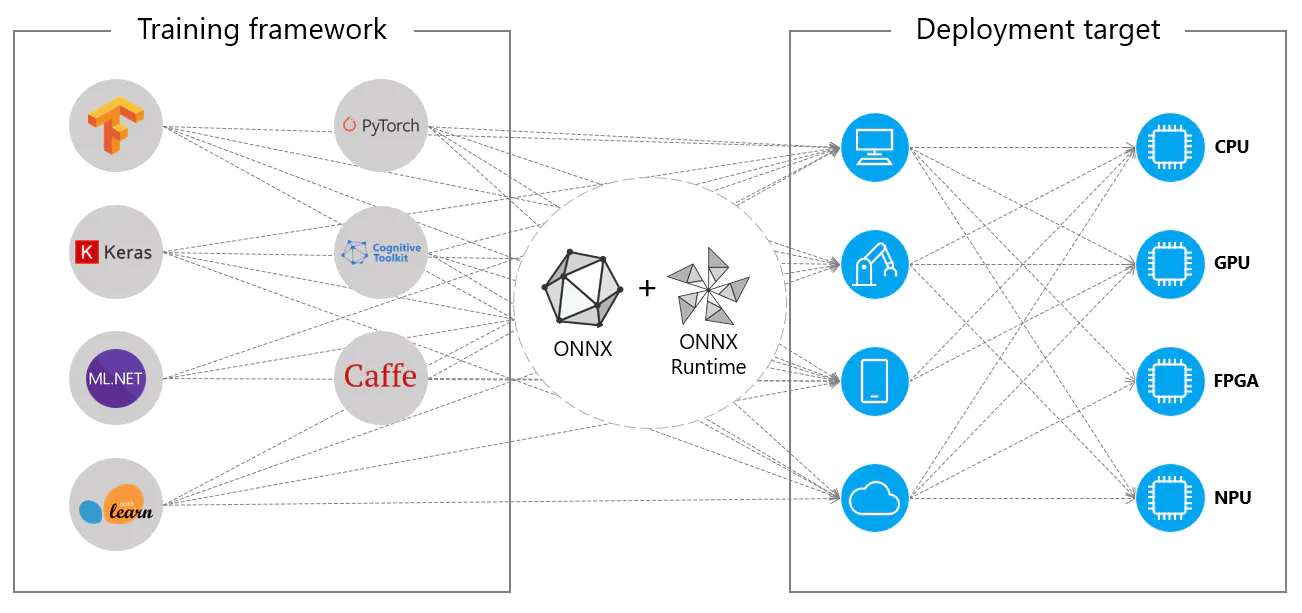

In [3]:
# Загружаем предобученную модель ResNet
model = models.resnet18(pretrained=True)
model.eval()  # Переключаем модель в режим оценки

# Создаем случайный тензор для входных данных
dummy_input = torch.randn(1, 3, 224, 224)  # Формат: [batch_size, channels, height, width]
dummy_output = model(dummy_input)
print(dummy_output.shape)

torch.Size([1, 1000])


Теперь, когда модель готова, пришло время экспортировать ее. Для этого используем метод torch.onnx.export()

In [5]:
checkpoint_path = "../checkpoints/resnet18.onnx"

torch.onnx.export(model, 
                  dummy_input, 
                  checkpoint_path, 
                  export_params=True, 
                  opset_version=11,  # Версия ONNX
                  do_constant_folding=True,  # Оптимизация
                  input_names=['input'],  # Названия входных слоев
                  output_names=['output'],  # Названия выходных слоев
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print("Модель успешно экспортирована в формат ONNX!")

Модель успешно экспортирована в формат ONNX!


### Оптимизируем inference с ONNX Runtime

In [57]:
ort_session = ort.InferenceSession(checkpoint_path, providers=['CPUExecutionProvider']) # 'CUDAExecutionProvider'

In [51]:
inputs = ort_session.get_inputs()
for item in inputs:
    print(f"Input name: {item.name}, shape: {item.shape}, type: {item.type}")

outputs = ort_session.get_outputs()
for item in outputs:
    print(f"Output name: {item.name}, shape: {item.shape}, type: {item.type}")

Input name: input, shape: ['batch_size', 3, 224, 224], type: tensor(float)
Output name: output, shape: ['batch_size', 1000], type: tensor(float)


In [52]:
# Выполняем предсказание
outputs = ort_session.run(None, {'input': np.array(dummy_input)})

# Вывод предсказания
predicted_class = np.argmax(outputs[0])
print(f"Предсказанный класс: {predicted_class}")

Предсказанный класс: 107


In [61]:
onnx_model = onnx.load(checkpoint_path)

# Проверка корректности
onnx.checker.check_model(onnx_model)
print("Model is valid!")

# Вывод информации о модели
print("Model IR version: ", onnx.version.version)
print("Model opset version: ", onnx_model.opset_import[0].version)

Model is valid!
Model IR version:  1.17.0
Model opset version:  11


In [54]:
# Вывод графа модели
print("Model graph:")
# print(onnx.helper.printable_graph(onnx_model.graph))

Model graph:


Теперь протестируем, как быстро работает наша модель.

In [58]:
get_mean_inference_time(ort_session, dummy_input, n=1000)

Среднее время предсказания: 0.0157 секунд


### Оптимизации ONNX Runtime

Уровни оптимизации:

- ORT_DISABLE_ALL — без оптимизаций.
- ORT_ENABLE_BASIC — базовые оптимизации.
- ORT_ENABLE_EXTENDED — расширенные оптимизации.
- ORT_ENABLE_ALL — все доступные оптимизации.

```
session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
```

### Многопоточность
ONNX Runtime поддерживает многопоточное выполнение для ускорения инференса на CPU.

In [59]:
session_options = ort.SessionOptions()

# Intra-Op Parallelism (параллелизм внутри одной операции)
session_options.intra_op_num_threads = 4  # Количество потоков

# Inter-Op Parallelism (параллелизм между операциями)
session_options.inter_op_num_threads = 2

ort_session = ort.InferenceSession(checkpoint_path, providers=['CPUExecutionProvider'], sess_options=session_options)

In [60]:
get_mean_inference_time(ort_session, dummy_input, n=1000)

Среднее время предсказания: 0.0098 секунд


### Квантизация
ONNX Runtime поддерживает квантизацию моделей для ускорения и уменьшения размера.

- Статическая квантизация (Static Quantization).
    Квантизует веса и активации.
- Динамическая квантизация (Dynamic Quantization). Квантизует только веса.

In [67]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Квантизация модели (преобразование весов в INT8)
quantized_model_path = "../checkpoints/resnet18_quantized.onnx"
quantize_dynamic(
    "../checkpoints/resnet18.onnx",
    quantized_model_path,
    weight_type=QuantType.QUInt8  # или QInt8
)

# Загрузка квантизованной модели
ort_session = ort.InferenceSession(quantized_model_path, providers=['CPUExecutionProvider'])

### Сравнение ONNX Runtime и OpenVINO

| Характеристика               | ONNX Runtime                                                                                     | OpenVINO                                                                                     |
|------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| Разработчик                  | Microsoft                                                                                      | Intel                                                                                         |
| Основная цель                | Кроссплатформенный инференс моделей ONNX на любых устройствах (CPU, GPU, TPU).                  | Оптимизация инференса специфично для аппаратных платформ Intel (CPU, iGPU, VPU, FPGA).         |
| Поддерживаемые устройства    | CPU, GPU (CUDA, DirectML, TensorRT), ARM, TPU, и другие.                                       | Только Intel-железо: CPU (включая Xeon), iGPU, VPU (Movidius), FPGA.                            |
| Поддерживаемые фреймворки    | ONNX (конвертация из PyTorch, TensorFlow, MXNet, и др.).                                        | ONNX, TensorFlow, PyTorch, Caffe, MXNet (через конвертацию в IR-формат OpenVINO).               |
| Оптимизации                  | Общие оптимизации графа, квантизация (INT8, FP16), многопоточность.                            | Глубокие аппаратные оптимизации для Intel (VNNI, AVX-512), квантизация (INT8, FP16), оптимизация графа. |
| Производительность           | Хорошая на любых платформах, но не максимальная на Intel.                                       | Максимальная производительность на Intel-железе (до 10x ускорение по сравнению с ONNX Runtime на CPU). |
| Кросс-платформенность        | Да (Windows, Linux, macOS, Android, iOS).                                                      | Ограничена Intel-платформами (хотя поддерживает Windows, Linux, macOS).                         |
| Удобство интеграции           | Простота использования, поддержка многих бэкендов (CUDA, TensorRT, DirectML).               | Требует конвертации в IR-формат, но даёт лучшую производительность на Intel.                   |
| Поддержка edge-устройств     | Да (например, Raspberry Pi с ARM).                                                              | Да, но только с Intel-процессорами (например, Raspberry Pi + Intel Movidius).                  |
| Примеры использования        | Облачные сервисы, кроссплатформенные приложения, где важна гибкость.                           | Локальные приложения на Intel-железе, edge-устройства, видеоаналитика.                        |
